# Trabalho Machine Learning I - Santander Coders Data Science 2023

Integrantes:
- Bruno Henrique
- Fernanda Beatriz Dallaqua
- Natália Alves Brito
- Vinícius D' Lucas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import auc

from sklearn.feature_selection import SelectFromModel
from scipy.stats import chi2_contingency
from scipy.stats import chi2

# Análise preliminar do DataFrame

#### FALTA FAZER UMA ANÁLISE PRELIMINAR DO DATASET COMO FIZEMOS EM TÉCNICAS DE PROGRAMAÇÃO...

In [2]:
path_train = 'playground-series-s3e2/train.csv'
df         = pd.read_csv(path_train)
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
5,5,Female,34.0,0,0,Yes,Private,Urban,84.35,22.2,Unknown,0
6,6,Female,53.0,0,0,Yes,Private,Rural,88.97,25.3,never smoked,0
7,7,Male,78.0,0,1,Yes,Self-employed,Rural,75.32,24.8,Unknown,0
8,8,Female,45.0,0,0,Yes,Private,Rural,107.22,34.1,never smoked,0
9,9,Female,62.0,0,0,Yes,Govt_job,Urban,62.68,18.4,formerly smoked,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [4]:
def get_valores_unicos(df, coluna):
    print(f'Os valores únicos para a coluna {coluna} são:')
    print(list(df[coluna].unique()))
    print()

In [5]:
get_valores_unicos(df,'gender')
get_valores_unicos(df,'ever_married')
get_valores_unicos(df,'work_type')
get_valores_unicos(df,'Residence_type')
get_valores_unicos(df,'smoking_status')
get_valores_unicos(df,'stroke')

Os valores únicos para a coluna gender são:
['Male', 'Female', 'Other']

Os valores únicos para a coluna ever_married são:
['Yes', 'No']

Os valores únicos para a coluna work_type são:
['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']

Os valores únicos para a coluna Residence_type são:
['Urban', 'Rural']

Os valores únicos para a coluna smoking_status são:
['never smoked', 'formerly smoked', 'Unknown', 'smokes']

Os valores únicos para a coluna stroke são:
[0, 1]



### Quantidade de amostras para cada gênero

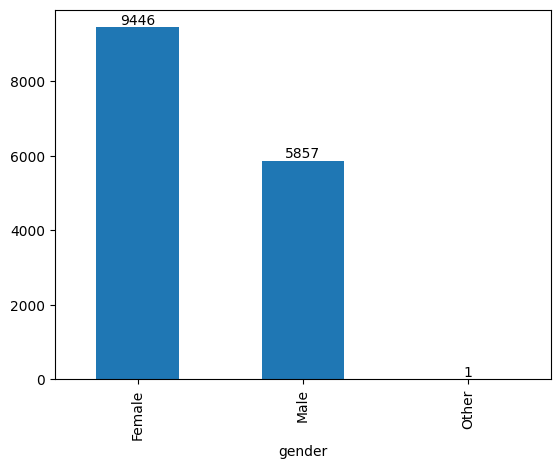

In [6]:
ax = df.gender.value_counts().plot(xlabel='gender', kind='bar');
ax.bar_label(ax.containers[0])
plt.show()

In [7]:
df[df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
9363,9363,Other,9.0,0,0,No,children,Rural,96.04,18.0,Unknown,0


In [8]:
df = df[df['gender']!='Other']

### Quantidade de amostras para ever_married

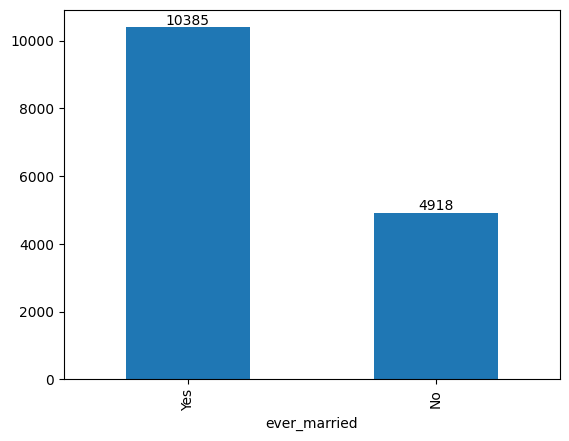

In [9]:
ax = df.ever_married.value_counts().plot(xlabel='ever_married', kind='bar');
ax.bar_label(ax.containers[0])
plt.show()

### Quantidade de amostras para cada classe em stroke

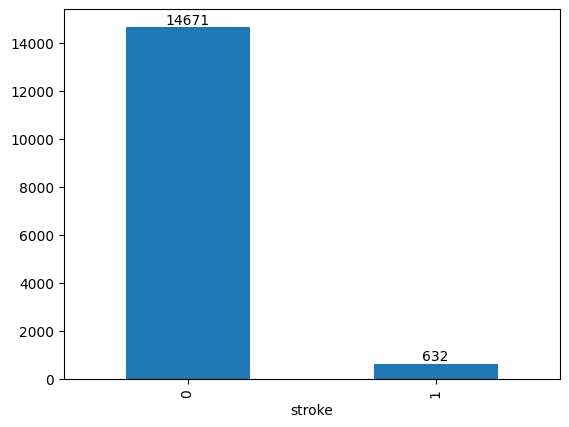

In [10]:
ax = df.stroke.value_counts().plot(xlabel='stroke', kind='bar');
ax.bar_label(ax.containers[0])
plt.show();

##### A partir do gráfico anterior observa-seum problema de desbalanceamento de amostras.

# Tratamento do DataFrame

### Considerações 

A ideia aqui foi transformar features categóricas em numéricas, atribuindo valores binários. A coluna gender for subdivida em outras 3 colunas binárias. A mesma lógica foi utilizada para as colunas work_type e residence_type.

Para a coluna smoking_status foram atribuídos os níveis de intensidade (0 para never smoked, 1 para formely smoked e 2 para smokes) e o unknown foi atribuído a outra coluna

In [11]:
# Criando função para transformar features categóricas em numéricas
def get_dummy(dataframe: pd.DataFrame, column: str) -> pd.DataFrame:
    series = df[column]
    dummy  = pd.get_dummies(series)
    
    return dummy

In [12]:
#Aplicando função para categorias gender, work e residence

df_gender_dummy = get_dummy(df,'gender')
df_work_dummy   = get_dummy(df,'work_type')
df_residence_dummy = get_dummy(df,'Residence_type')

In [13]:
ever_married = df['ever_married']
ever_married_bin = []
for x in ever_married:
    if x == 'Yes': ever_married_bin.append(1)
    else: ever_married_bin.append(0)
df['ever_married_bin'] = ever_married_bin   

In [14]:
# Atribuindo valores numéricos (ou níveis) para a feature smoking_status
smoking_status = df['smoking_status']
smoking_value  = []
for x in smoking_status:
    if x == 'never smoked': 
        smoking_value.append(1)
    elif x == 'formerly smoked': 
        smoking_value.append(2)
    elif x == 'smokes':
        smoking_value.append(3)
    else:
        smoking_value.append(0)
df['smoking_status_value'] = smoking_value

In [15]:
# Concatenando valores para o novo datafarme
df_processed = pd.concat([df,df_gender_dummy,df_work_dummy,df_residence_dummy],axis=1)
df_processed.drop(columns=['gender','ever_married','work_type','Residence_type','smoking_status'],inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15303 entries, 0 to 15303
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15303 non-null  int64  
 1   age                   15303 non-null  float64
 2   hypertension          15303 non-null  int64  
 3   heart_disease         15303 non-null  int64  
 4   avg_glucose_level     15303 non-null  float64
 5   bmi                   15303 non-null  float64
 6   stroke                15303 non-null  int64  
 7   ever_married_bin      15303 non-null  int64  
 8   smoking_status_value  15303 non-null  int64  
 9   Female                15303 non-null  bool   
 10  Male                  15303 non-null  bool   
 11  Govt_job              15303 non-null  bool   
 12  Never_worked          15303 non-null  bool   
 13  Private               15303 non-null  bool   
 14  Self-employed         15303 non-null  bool   
 15  children              15

In [16]:
df_processed

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,ever_married_bin,smoking_status_value,Female,Male,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
0,0,28.0,0,0,79.53,31.1,0,1,1,False,True,False,False,True,False,False,False,True
1,1,33.0,0,0,78.44,23.9,0,1,2,False,True,False,False,True,False,False,True,False
2,2,42.0,0,0,103.00,40.3,0,1,0,True,False,False,False,True,False,False,True,False
3,3,56.0,0,0,64.87,28.8,0,1,1,False,True,False,False,True,False,False,False,True
4,4,24.0,0,0,73.36,28.8,0,0,1,True,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15299,15299,22.0,0,0,72.63,19.5,0,0,1,True,False,True,False,False,False,False,False,True
15300,15300,46.0,1,0,101.19,32.1,0,1,1,True,False,False,False,True,False,False,False,True
15301,15301,75.0,0,0,87.69,26.2,0,1,1,True,False,False,False,False,True,False,False,True
15302,15302,46.0,0,0,101.13,22.5,0,1,0,False,True,False,False,True,False,False,True,False


# Análise estatística e seleção de Features

##### Para tentar maximizar o aprendizado do modelo, primeiramente fizemos um teste de correlação de variáveis para poder selecionar melhor as features a serem utilizadas nos modelos.


In [17]:
# Definindo função para computar correlação entre as variáveis e plotar como heatmap
def correlation_analysis(df):
  correlation_matrix = df.corr(numeric_only=True)

  plt.figure(figsize=(16, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
  plt.title("Matriz de Correlação")
  plt.show()
  return(correlation_matrix) 

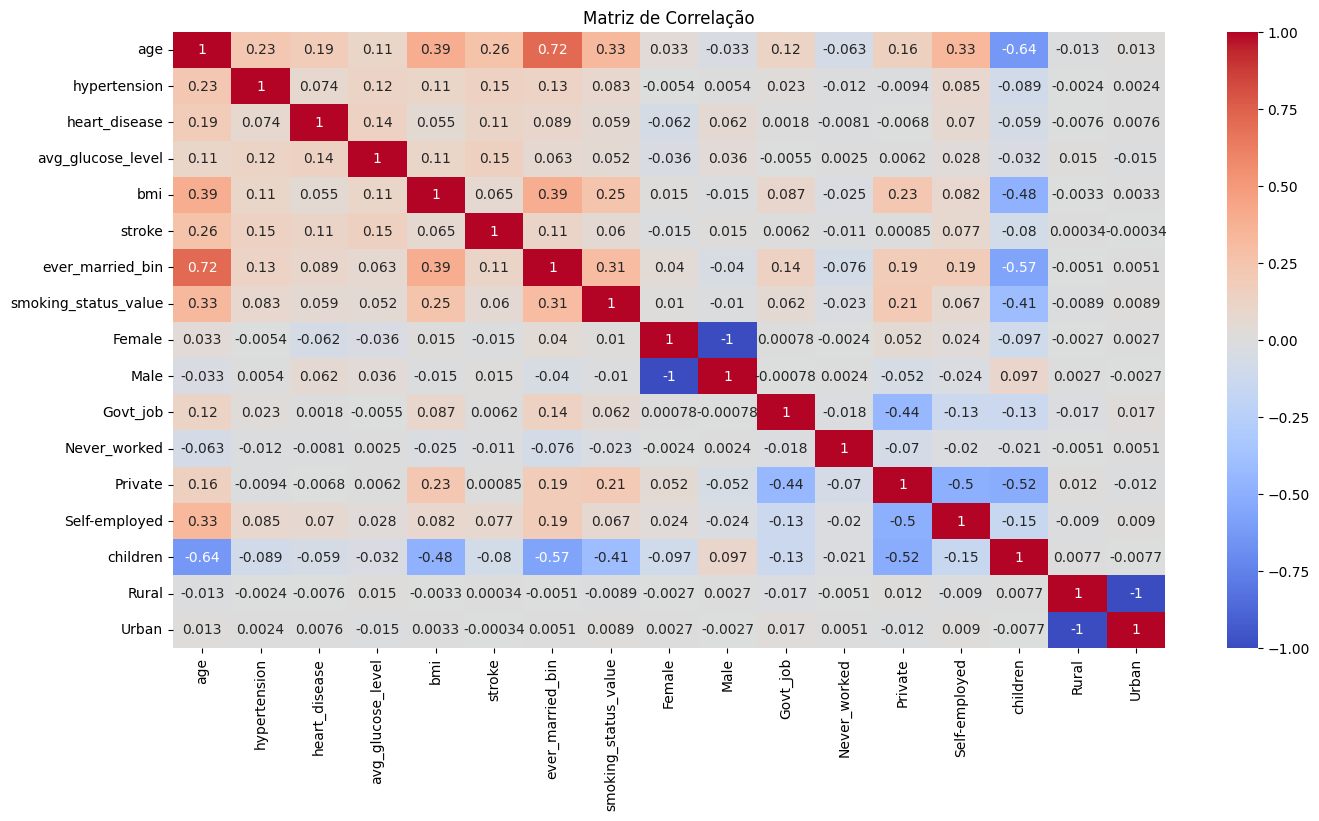

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,ever_married_bin,smoking_status_value,Female,Male,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
age,1.000000,0.232624,0.193394,0.108933,0.390630,0.261319,0.716924,0.327354,0.032896,-0.032896,0.119574,-0.062535,0.156003,0.328593,-0.638627,-0.013171,0.013171
hypertension,0.232624,1.000000,0.074176,0.122838,0.106651,0.145892,0.128458,0.083491,-0.005404,0.005404,0.022794,-0.012001,-0.009351,0.085466,-0.088756,-0.002448,0.002448
heart_disease,0.193394,0.074176,1.000000,0.137151,0.054571,0.111516,0.088743,0.058900,-0.061780,0.061780,0.001784,-0.008108,-0.006755,0.069972,-0.059287,-0.007592,0.007592
avg_glucose_level,0.108933,0.122838,0.137151,1.000000,0.108177,0.149278,0.063019,0.052166,-0.035529,0.035529,-0.005456,0.002466,0.006208,0.028386,-0.032141,0.015034,-0.015034
bmi,0.390630,0.106651,0.054571,0.108177,1.000000,0.065377,0.394585,0.250858,0.015317,-0.015317,0.087409,-0.024596,0.232501,0.082282,-0.483114,-0.003306,0.003306
stroke,0.261319,0.145892,0.111516,0.149278,0.065377,1.000000,0.113998,0.059724,-0.014940,0.014940,0.006222,-0.010888,0.000855,0.076928,-0.080364,0.000345,-0.000345
ever_married_bin,0.716924,0.128458,0.088743,0.063019,0.394585,0.113998,1.000000,0.311284,0.039644,-0.039644,0.140129,-0.076233,0.192389,0.188092,-0.568599,-0.005123,0.005123
smoking_status_value,0.327354,0.083491,0.058900,0.052166,0.250858,0.059724,0.311284,1.000000,0.010192,-0.010192,0.062204,-0.023475,0.207899,0.067152,-0.411372,-0.008935,0.008935
Female,0.032896,-0.005404,-0.061780,-0.035529,0.015317,-0.014940,0.039644,0.010192,1.000000,-1.000000,0.000776,-0.002377,0.051574,0.023896,-0.096715,-0.002715,0.002715
Male,-0.032896,0.005404,0.061780,0.035529,-0.015317,0.014940,-0.039644,-0.010192,-1.000000,1.000000,-0.000776,0.002377,-0.051574,-0.023896,0.096715,0.002715,-0.002715


In [18]:
# Computando correlação para o dataset corrigido

correlation_analysis(df_processed.drop(columns='id'))

##### Apesar de termos gerado uma matriz de correlação. A correlação de Pearson não é a métrica mais adequada para avaliar a correlação de variáveis binárias dicotômicas. Dessa forma, iremos realizar o teste de Qui-quadrado para avaliar se as features binárias são correlacionadas. O importante do cálculo anterior é: As variáveis contínuas não são correlacionadas. O teste do chi-quadrado tem a hipótese nula que as duas variáveis (nesse caso binárias) não tem correlação entre si. Caso passe no teste para determinado nível de significância, terá como saída TRUE.

In [19]:
def perform_chi_square_test(pair, df,significance_level):
    col1, col2 = pair
    cross_tab = pd.crosstab(df[col1], df[col2])
    chi_sq_result = chi2_contingency(cross_tab)
    p_value = chi_sq_result[1]
    return col1, col2, "reject" if p_value < significance_level else "accept"

def chi_square_test(df, significance_level):
    binary_columns = df.select_dtypes(include='int64').columns
    column_pairs = [(col1, col2) for col1 in binary_columns for col2 in binary_columns if col1 != col2]

    # Use multiprocessing to parallelize the chi-square tests
    with Pool(processes=4) as pool:  # Adjust the number of processes as needed
        results = pool.starmap(perform_chi_square_test, [(pair, df) for pair in column_pairs])

    result_matrix = pd.DataFrame(results, columns=['Column1', 'Column2', 'Result'])
    result_matrix = result_matrix.pivot(index='Column1', columns='Column2', values='Result')

    return result_matrix


In [80]:
'''
Assumption(H0): The two columns are NOT related to each other
Result of Chi-Sq Test: The Probability of H0 being True
'''


def chi_square_test(df, significance_level):
    def perform_chi_square_test(col1, col2):
        cross_tab = pd.crosstab(df[col1], df[col2])
        chi_sq_result = chi2_contingency(cross_tab)
        p_value = chi_sq_result[1]
        return 0 if p_value < significance_level else 1

    binary_columns = df.select_dtypes(include=['int64','bool']).columns
    result_matrix = pd.DataFrame(index=binary_columns, columns=binary_columns)

    for col1 in binary_columns:
        for col2 in binary_columns:
            result_matrix.at[col1, col2] = perform_chi_square_test(col1, col2)

    return result_matrix

In [78]:
binary_correlation_matrix = chi_square_test(df_processed.drop(columns='id'),0.05)
binary_correlation_matrix

,hypertension,heart_disease,stroke,ever_married_bin,smoking_status_value,Female,Male,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
hypertension,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
heart_disease,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
stroke,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
ever_married_bin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
smoking_status_value,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Female,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
Male,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
Govt_job,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Never_worked,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
Private,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


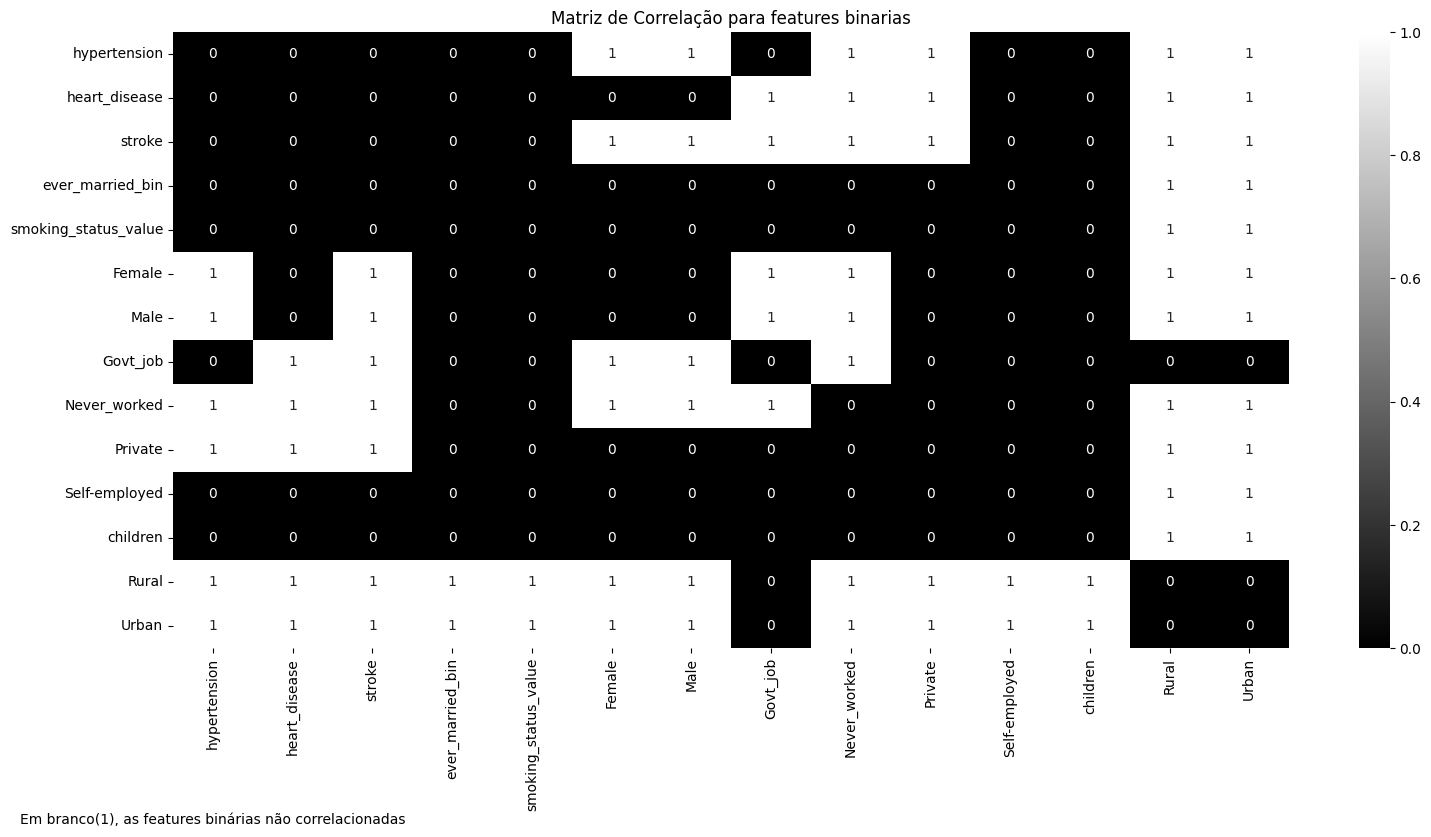

In [97]:
plt.figure(figsize=(18, 8))
sns.heatmap(binary_correlation_matrix.astype(float), annot=True, cmap='gist_gray')
plt.title("Matriz de Correlação para features binarias")
plt.text(0.5, 18, "Em branco(1), as features binárias não correlacionadas", fontsize=10, ha="center")
plt.show()


In [59]:
sum_of_non_correlated_features = chi_square_test(df_processed.drop(columns=['id','stroke','smoking_status_value']),0.05).sum()
sum_of_non_correlated_features.sort_values(ascending=False)

Rural               9
Urban               9
Never_worked        7
hypertension        6
heart_disease       5
Female              5
Male                5
Govt_job            4
Private             4
ever_married_bin    2
Self-employed       2
children            2
dtype: object

##### Ranking de Importância de features baseada em diminuição média de impureza

##### Uma forma de tentar selecionar as melhores features para o nosso modelo é gerar o índice de Gini a partir de um modelo de árvores de decisão. Para isto, escolhemos o classificador Extra-Trees para gerar, a partir de 100 árvores aleatórias, as métricas de impureza para as features do nosso dataframe.

In [98]:
# Removendo do dataset as colunas id e stroke

columns = list(df_processed.columns)
columns.remove('id')
columns.remove('stroke')

X = df_processed[columns]
y = df_processed['stroke']


# Esse conjunto de amostras só está sendo utilizado para verificar quais as melhores features para o modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 53, stratify = y, shuffle=True)


In [103]:
# Utilizando esamble trees para 

features_names = columns
clf = ExtraTreesClassifier(n_estimators=100, random_state = 36)
clf = clf.fit(X_train, y_train)


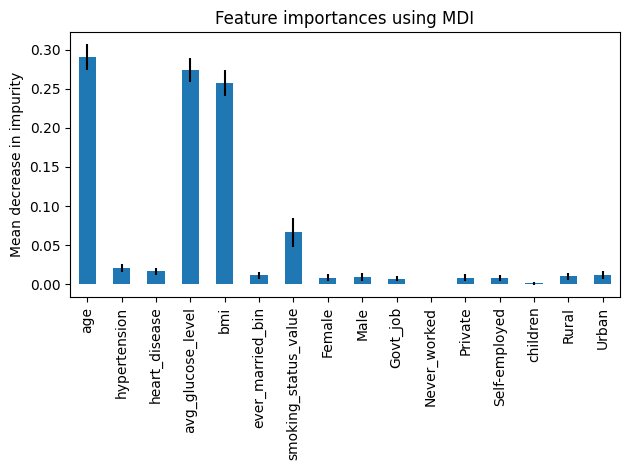

In [104]:
forest_importances = pd.Series(clf.feature_importances_, index=columns)
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [105]:
forest_importances.sort_values(ascending=False)

age                     0.290567
avg_glucose_level       0.273813
bmi                     0.256889
smoking_status_value    0.066394
hypertension            0.020626
heart_disease           0.016440
Urban                   0.011783
ever_married_bin        0.011264
Rural                   0.010119
Male                    0.008791
Private                 0.008550
Female                  0.008253
Self-employed           0.008191
Govt_job                0.007001
children                0.001305
Never_worked            0.000015
dtype: float64

##### Vamos selecionar as 5 features com melhor índice de Gini

In [120]:
selected_row_names_gini = forest_importances.sort_values(ascending=False)[0:5].index
selected_row_names_gini

Index(['age', 'avg_glucose_level', 'bmi', 'smoking_status_value',
       'hypertension'],
      dtype='object')

##### Em relação as features binárias, vamos relecionar as features que não tem correlação com a feature binária hypertension

In [121]:
binary_correlation_matrix[binary_correlation_matrix['hypertension'] == 1]['hypertension']
selected_row_names_corr = binary_correlation_matrix[binary_correlation_matrix['hypertension'] == 1]['hypertension'].index
selected_row_names_corr

Index(['Female', 'Male', 'Never_worked', 'Private', 'Rural', 'Urban'], dtype='object')

In [169]:
# juntando as listas de feições para classificação

selected_features = list(selected_row_names_corr) + list(selected_row_names_gini)
selected_features = list(selected_row_names_gini)
selected_features 

['age', 'avg_glucose_level', 'bmi', 'smoking_status_value', 'hypertension']

# Amostragem

##### Para amostragem, foi decidido realizar uma amostragem aleatória estratificada pelas proporções da classe 'stroke'. Dessa forma, como existe poucos valores de 'stroke' no daframe, decidimos separar as amostras em 0.8 para treinamento e 0.2 para teste/validação dos modelos.

##### Como vimos que o modelo está desbalanceado. Utilizamos a técnida de downsampling da classe que possui mais amostras ('non_stroke'). Dessa forma, selecionamos de forma aleatória e reprodutível, um número de amostras para classe 'non_stroke' que é exatamente a quantidade de amostras que temos no dataframe para stroke.

In [181]:
# Reamostrando a classe com mais amostras (downsampling)
not_stroke = df_processed[df_processed['stroke']==0]
stroke     = df_processed[df_processed['stroke']==1]
not_stroke_downsampled = resample(not_stroke,
                                replace = False, # sample without replacement
                                n_samples = len(stroke), # match minority n
                                random_state = 27)
print(not_stroke_downsampled.shape)

downsampled = pd.concat([not_stroke_downsampled, stroke])

(632, 18)


In [171]:
downsampled

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,ever_married_bin,smoking_status_value,Female,Male,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
6091,6091,39.00,0,0,82.85,41.7,0,1,0,True,False,True,False,False,False,False,False,True
2751,2751,5.00,0,0,80.84,16.6,0,0,0,False,True,False,False,False,False,True,True,False
13785,13785,1.64,0,0,170.88,17.3,0,0,0,True,False,False,False,False,False,True,True,False
9156,9156,51.00,0,0,111.92,27.7,0,1,0,True,False,False,False,False,True,False,False,True
10112,10112,56.00,0,0,82.37,35.6,0,1,2,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15225,15225,76.00,0,1,60.98,29.1,1,1,1,True,False,False,False,True,False,False,True,False
15246,15246,81.00,0,0,95.84,23.4,1,1,0,False,True,False,False,False,True,False,True,False
15250,15250,67.00,0,0,98.39,44.1,1,1,2,False,True,False,False,False,True,False,True,False
15275,15275,69.00,0,0,99.10,22.7,1,1,2,True,False,False,False,True,False,False,False,True


# Classificações

#### Foram escolhidos três classificadores distintos para o projeto, levando em consideração três critérios: serem classificadores de escopo diferente, não fazerem suposições explícitas sobre a distribuição dos dados e serem adequados a classificações Binárias. Assim, escolhemos os classificadores:

##### > Regressão Logística (modelo de classificação linear);
##### > Random Forest (modelo de classificação por árvores de decisão);
##### > Multiple layer perceptron (modelo de classificação linear por redes neurais);

### Análise de parâmetros dos classificadores

### Classificações sem balanceamento de amostras

In [27]:
columns = list(df_processed.columns)
columns.remove('id')

df_processed.drop_duplicates(subset=columns, inplace=True)


In [28]:
columns = list(df_processed.columns)
columns.remove('id')
columns.remove('stroke')

X = df_processed[columns]
y = df_processed['stroke']

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y, shuffle=True)

(15303, 16)


In [26]:
RF = RandomForestClassifier(class_weight = 'balanced_subsample', random_state=15)

RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)

CR = classification_report(y_test, y_pred)

print(CR)

precision, recall, _ = precision_recall_curve(y_test, RF.predict_proba(X_test)[:, 1])
auc_score = auc(recall, precision)
print('pr modelo: ', auc_score) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2935
           1       0.46      0.05      0.09       126

    accuracy                           0.96      3061
   macro avg       0.71      0.52      0.53      3061
weighted avg       0.94      0.96      0.94      3061

pr modelo:  0.2260315356609509


In [29]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [32]:
LR     = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

CR = classification_report(y_test, y_pred)

print(CR)

precision, recall, _ = precision_recall_curve(y_test, LR.predict_proba(X_test)[:, 1])
auc_score = auc(recall, precision)
print('pr modelo: ', auc_score) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2935
           1       0.60      0.02      0.05       126

    accuracy                           0.96      3061
   macro avg       0.78      0.51      0.51      3061
weighted avg       0.94      0.96      0.94      3061

pr modelo:  0.5205815093106828


/home/fernanda/anaconda3/envs/env_ada2/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [139]:
columns_importance = ['age','avg_glucose_level','bmi','smoking_status_value']

X_imp = df_processed[columns_importance]
y_imp = df_processed['stroke']

X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(X_imp, y_imp, test_size=0.2, random_state=42, stratify = y_imp, shuffle=True)

In [140]:
RF_imp = RandomForestClassifier(class_weight = 'balanced_subsample', random_state=15)

RF_imp.fit(X_train_imp, y_train_imp)

y_pred_imp = RF_imp.predict(X_test_imp)

CR_imp = classification_report(y_test_imp, y_pred_imp)

print(CR_imp)

precision_imp, recall_imp, _ = precision_recall_curve(y_test_imp, RF_imp.predict_proba(X_test_imp)[:, 1])
auc_score_imp = auc(recall_imp, precision_imp)
print('pr modelo: ', auc_score_imp) 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2935
           1       0.44      0.06      0.11       126

    accuracy                           0.96      3061
   macro avg       0.70      0.53      0.54      3061
weighted avg       0.94      0.96      0.94      3061

pr modelo:  0.22566195307822118


In [33]:
dummy1 = DummyClassifier(strategy='most_frequent', random_state=0)
dummy1.fit(X_train_scaled, y_train)
print('dummy:', dummy1.score(X_test_scaled, y_test))
precision, recall, _ = precision_recall_curve(y_test, dummy1.predict_proba(X_test)[:, 1])
auc_dummy = auc(recall, precision)
print('auc dummy: ', auc_dummy)

dummy: 0.9588369813786344
auc dummy:  0.5205815093106828


### Classificações com balanceamento de amostras

In [172]:
downsampled = pd.concat([not_stroke_downsampled, stroke])
downsampled

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,ever_married_bin,smoking_status_value,Female,Male,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban
6091,6091,39.00,0,0,82.85,41.7,0,1,0,True,False,True,False,False,False,False,False,True
2751,2751,5.00,0,0,80.84,16.6,0,0,0,False,True,False,False,False,False,True,True,False
13785,13785,1.64,0,0,170.88,17.3,0,0,0,True,False,False,False,False,False,True,True,False
9156,9156,51.00,0,0,111.92,27.7,0,1,0,True,False,False,False,False,True,False,False,True
10112,10112,56.00,0,0,82.37,35.6,0,1,2,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15225,15225,76.00,0,1,60.98,29.1,1,1,1,True,False,False,False,True,False,False,True,False
15246,15246,81.00,0,0,95.84,23.4,1,1,0,False,True,False,False,False,True,False,True,False
15250,15250,67.00,0,0,98.39,44.1,1,1,2,False,True,False,False,False,True,False,True,False
15275,15275,69.00,0,0,99.10,22.7,1,1,2,True,False,False,False,True,False,False,False,True


In [173]:
X = downsampled[selected_features]
y = downsampled['stroke']
target_names = ['non_stroke', 'stroke']

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify = y, shuffle=True)

(1264, 5)


##### Random Forest

In [174]:
RF = RandomForestClassifier(class_weight = 'balanced_subsample', random_state=15)

RF.fit(X_train, y_train)

y_pred_rf = RF.predict(X_test)

CR = classification_report(y_test, y_pred_rf,target_names=target_names)

print(CR)

precision, recall, _ = roc_curve(y_test, y_pred_rf)
auc_score_rf = auc(precision, recall)


prf= precision_recall_fscore_support(y_test, y_pred_rf, average = 'binary', beta=2)
recall_rf = prf[1]
f1_score_rf = prf[2]
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

print('pr modelo: ', auc_score_rf) 

              precision    recall  f1-score   support

  non_stroke       0.82      0.81      0.82       127
      stroke       0.81      0.83      0.82       126

    accuracy                           0.82       253
   macro avg       0.82      0.82      0.82       253
weighted avg       0.82      0.82      0.82       253

pr modelo:  0.8182102237220348


In [175]:
print(recall_rf, f1_score_rf, mcc_rf, auc_score_rf)

0.8253968253968254 0.8227848101265822 0.6364602224791037 0.8182102237220348


##### Regressão Logística

In [176]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [177]:
LR     = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)
y_pred_lr = LR.predict(X_test_scaled)

CR = classification_report(y_test, y_pred_lr,target_names=target_names)

print(CR)

precision, recall, _ = roc_curve(y_test, y_pred_lr)
auc_score_lr = auc(precision, recall)


prf= precision_recall_fscore_support(y_test, y_pred_lr, average = 'binary', beta=2)
recall_lr = prf[1]
f1_score_lr = prf[2]
mcc_lr = matthews_corrcoef(y_test, y_pred_lr)

print('pr modelo: ', auc_score_lr) 

              precision    recall  f1-score   support

  non_stroke       0.80      0.83      0.81       127
      stroke       0.82      0.79      0.81       126

    accuracy                           0.81       253
   macro avg       0.81      0.81      0.81       253
weighted avg       0.81      0.81      0.81       253

pr modelo:  0.8102112235970503


In [178]:
print(recall_lr, f1_score_lr, mcc_lr, auc_score_lr)

0.7936507936507936 0.7987220447284346 0.6208105265760122 0.8102112235970503


### Multiple Layer Perceptron

In [179]:
MLP = MLPClassifier(hidden_layer_sizes=(500,),random_state=1, max_iter=500, learning_rate_init=0.001).fit(X_train_scaled, y_train)
y_pred_mlp = MLP.predict(X_test_scaled)

CR = classification_report(y_test, y_pred_mlp, target_names=target_names)

print(CR)

precision, recall, _ = roc_curve(y_test, y_pred_rf)
auc_score_mlp = auc(precision, recall)


prf= precision_recall_fscore_support(y_test, y_pred_mlp, average = 'binary', beta=2)
recall_mlp = prf[1]
f1_score_mlp = prf[2]
mcc_mlp = matthews_corrcoef(y_test, y_pred_mlp)

print('pr modelo: ', auc_score_mlp) 

              precision    recall  f1-score   support

  non_stroke       0.81      0.79      0.80       127
      stroke       0.79      0.81      0.80       126

    accuracy                           0.80       253
   macro avg       0.80      0.80      0.80       253
weighted avg       0.80      0.80      0.80       253

pr modelo:  0.8182102237220348


In [180]:
print(recall_mlp, f1_score_mlp, mcc_mlp, auc_score_mlp)

0.8095238095238095 0.8056872037914692 0.5970373253282858 0.8182102237220348


## Avaliação e comparação dos modelos de classificação

##### Primeiro é necessário confirmar se o resultado de cada classificador é significativamente diferente. Para isso utilizaremos o teste de McNemar. 
(Thomas G. Dietterich; Approximate Statistical Tests for Comparing Supervised Classification Learning Algorithms. Neural Comput 1998; 10 (7): 1895–1923. doi: https://doi.org/10.1162/089976698300017197)


![McNemar's test](Mcnemars_test.png)


##### A hipótese hula do teste de McNemar é de que dois algoritmos tenham a mesma taxa de erro. Se a hipótese nula for REJEITADA podemos afirmar que não há motivos para discordar, em determinado nível de significância, que os dois algoritmos tem diferentes performances quando treinados com o mesmo conjunto amostral.

In [188]:
def mcnemar_test(y_1, y_2, y_test, alpha=0.05):
    
    if len(y_1) != len(y_2) or len(y_1) != len(y_test):
        raise ValueError("Os tamanhos de y_1, y_2 e y_test devem ser iguais.")

    b = np.logical_and((y_1 != y_test),(y_2 == y_test)).sum()
    c = np.logical_and((y_1 == y_test),(y_2 != y_test)).sum()
    
    chi2_stat = ((np.abs(b - c) - 1)**2 )/ (b + c)

    # p_value for chi2 distribuition
    p_value = 1 - chi2.cdf(chi2_stat, 1)

    # testing null hyposthesis 
    return p_value < alpha


def pairwise_mcnemar_tests(y_prediction, y_test, alpha=0.05):
    num_classifiers = len(y_prediction)
    results_matrix = [['-' for _ in range(num_classifiers)] for _ in range(num_classifiers)]

    for i in range(num_classifiers):
        for j in range(i + 1, num_classifiers):
            H0 = mcnemar_test(y_prediction[i], y_prediction[j], y_test, alpha)
            results_matrix[i][j] = H0
            results_matrix[j][i] = H0

    return results_matrix

In [189]:
# Atribuindo o conjunto teste e a predição de cada modelo a uma variável do tipo numpy_array

true_labels = np.array(y_test)

rf_predict = np.array(y_pred_rf)
lr_predict = np.array(y_pred_lr)
mlp_predict = np.array(y_pred_mlp)

y_prediction = [rf_predict, lr_predict, mlp_predict]

In [190]:
# Realizando o teste de McNemar para cada par de classificadores
results_matrix = pairwise_mcnemar_tests(y_prediction,true_labels, alpha=0.05)
result_df = pd.DataFrame(results_matrix, columns=["RF","LR","MLP"], index=["RF","LR","MLP"])
result_df

,RF,LR,MLP
RF,-,False,False
LR,False,-,False
MLP,False,False,-


##### Como a relação 2 a 2 passou no teste em todas as combinações, podemos dizer que estatísticamente, os resultados de classificação são diferentes.

##### Depois de comparar se os erros dos classificadores são significativamente semelhantes em relação a mesma amostra de teste, vamos comparar o desempenho individual deles em relação a uma referência.
##### Sabendo que a acurácia não é uma métrica muitas vezes confiável, iremos utilizar as métricas Recall, f1-Score, AUC Score e o coeficiente de correlação de Matthews(MCC) [Matthews, 1975] para comparar os classificadores. O motivo da escolha das métricas é: é melhor ter um modelo que classifica um falso positivo do que um falso negativo. Pensando nisso, escolhemos métricas relacionadas com o Recall. Um ponto importante a se pontuar é: a nossa métrica de f1-score será calculada de forma diferente, atribuindo um parâmetro de peso MAIOR para o recall (beta = 2).

##### O método usado para comparar os classificadores será o da distância euclidiana. Como ele funciona?


![Distância euclidiana](dist_euclidiana.png)



##### Bem, iremos computar as métricas Recall, f1-Score, MCC e AUC Score para cada modelo e calcular a distância dessas métricas para um ponto de referência considerado ÓTIMO. Nesse caso, os valores que gostaríamos de encontrar na melhor classificação possível (hipotética) são Recall = 1, f1-Score = 1, MCC = 1 e AUC Score = 1.

##### Portanto, iremos calcular a distancia do ponto (Recall, f1-Score, MCC, AUC Score) ao ponto ótimo (1,1,1,1), para cada modelo.

In [185]:
def distances_to_reference(data, recalls, f1_scores, mcc_scores, auc_scores, classifier_names, reference_point):
    
    # Calcular as distâncias euclidianas para cada classificador
    distances = [np.sqrt((r - reference_point[0])**2 + (f - reference_point[1])**2 + (m - reference_point[2])**2 + (a - reference_point[3])**2) for r, f, m, a in zip(recalls, f1_scores, mcc_scores, auc_scores)]

    distance_series = pd.Series(distances, name='Distance')

    df = pd.concat([data, distance_series ], axis=1)

    return df

In [186]:
data = {
    'Classifier names' : ["Logistic Regression", "Random Forest", "Multiple Layer Perceptron"],
    'Recall': [recall_lr, recall_rf, recall_mlp],
    'F1-Score': [f1_score_lr,f1_score_rf,f1_score_mlp],
    'AUC Score': [auc_score_lr,auc_score_rf,auc_score_mlp],
    'MCC' : [mcc_lr, mcc_rf, mcc_mlp]
}


df = pd.DataFrame(data)


distances_to_reference(df, df['Recall'], df['F1-Score'],df['MCC'], df['AUC Score'], df['Classifier names'],(1,1,1,1))



,Classifier names,Recall,F1-Score,AUC Score,MCC,Distance
0,Logistic Regression,0.793651,0.798722,0.810211,0.620811,0.512735
1,Random Forest,0.825397,0.822785,0.818210,0.636460,0.476550
2,Multiple Layer Perceptron,0.809524,0.805687,0.818210,0.597037,0.519100
